## Problema - Numerical Methods in Engineering with Python 3 
<p>Usando as primeiras aproximações de diferença central para transformar o problema do valor limite, com o método de diferenças finitas para a equação:
        $$y'' + 2y(2xy' + y) = 0,$$
        $$y(0) = 1/2, y'(1) = −2/9.$$ 
        Em que a solução exata é:
            $$y = 1/(2 + x 2 ).$$</p>

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.rc={'figure.figsize': (12, 6)}

## Swap
<p>A função swapRows troca as linhas $i$ e $j$ de uma matriz ou vetor $\mathbf{v}$, enquanto swapCols troca as colunas $i$ e $j$ de uma matriz.<p>

In [16]:
def swapRows(v, i, j):
    if len(v.shape) == 1:
        v[i],v[j] = v[j],v[i]
    else:
        v[[i,j],:] = v[[j,i],:]

In [17]:
def swapCols(v, i, j):
    v[:,[i,j]] = v[:,[j,i]]

## Eliminação de Gauss

<p>A eliminação de Gauss é o método mais conhecido para resolver equações simultâneas. Consiste em duas partes: a fase de eliminação e a fase de substituição traseira. A função da fase de eliminação é transformar as equações $\mathbf{Ax = b}$ na forma $\mathbf{Ux = c}$.</p>

<p>A função gaussPivot executa a eliminação de Gauss com o troca da linha.</p>

In [18]:
def gaussPivot(a, b, tol=1.0e-12):
    """
    Resolve [a] {x} = {b} pela eliminação de Gauss com pivô de linha em escala
    """
    
    n = len(b)
    
    #Fatores de escala
    s = np.zeros(n)
    for i in range(n):
        s[i] = max(abs(a[i,:]))

    for k in range(0, n-1):

      #Troca de linha
        p = np.argmax(abs(a[k:n, k])/s[k:n]) + k
        if abs(a[p, k]) < tol: print('Matriz é singular')
        if p != k:
            swapRows(b, k, p)
            swapRows(s, k, p)
            swapRows(a, k, p)

      #Eliminação
        for i in range(k+1, n):
            if a[i, k] != 0.0:
                lam = a[i, k]/a[k, k]
                a[i, k+1:n] = a [i, k+1:n] - lam*a[k, k+1:n]
                b[i] = b[i] - lam*b[k]
    if abs(a[n-1,n-1]) < tol: print('Matriz é singular')

    #Substituição de volta/retorno
    b[n-1] = b[n-1]/a[n-1, n-1]
    for k in range(n-2, -1, -1):
        b[k] = (b[k] - np.dot(a[k, k+1:n], b[k+1:n]))/a[k, k]
    return b

## Método Newton-Raphson
<p>O algoritmo Newton-Raphson é o método mais conhecido para encontrar raízes, por um bom motivo: é simples e rápido. A única desvantagem do método é que ele usa a derivada $f'(x)$ da função, bem como a própria função $f(x)$. Portanto, o método Newton-Raphson é utilizável apenas em problemas em que $f'(x)$ pode ser facilmente calculado.</p>

<p>Para derivar o método Newton-Raphson para um sistema de equações, começamos com a expansão da série Taylor de $f_{i}(x)$ sobre o ponto $x$:</p>

<p>$$f_{i}(\mathbf{x} + \Delta \mathbf{x}) = f_{i}(\mathbf{x}) + \sum_{j = 1}^{n}\frac{\partial f_{i}}{\partial x_{j}}\Delta x_{j} + O(\Delta x^{2})$$</p>

<p>Desconsiderando os termos de ordem $\Delta x^{2}$, podemos escrever a equação acima como:</p>

<p>$$\mathbf{f}(\mathbf{x} +  \mathbf{\Delta x}) = \mathbf{ f(x) +  J(x)\Delta x}, J_{ij} = \frac{\partial f_{i}}{\partial x_{j}}$$</p>


<p>Observe que a equação acima é uma aproximação linear (vetor $\Delta x$ sendo a variável) da função de valor vetorial $f$ na vizinhança do ponto $x$. Onde $J(x)$ é a matriz jacobiana (de ordem $n \times n$) composta pelas derivadas parciais.</p>

In [19]:
def newtonRaphson2(f, x, tol=1.0e-9):
    """
    Resolve as equações simultâneas f(x) = 0 pelo método de Newton-Raphson usando {x} como estimativa inicial.
    Observe que {f} e {x} são vetores.
    """
    
    def jacobian(f, x):
        h = 1.0e-6
        n = len(x)
        jac = np.zeros((n, n))
        f0 = f(x)
        for i in range(n):
            temp = x[i]
            x[i] = temp + h
            f1 = f(x)
            x[i] = temp
            jac[:,i] = (f1 - f0)/h
        return jac, f0
    
    for i in range(30):
        jac,f0 = jacobian(f, x)
        if np.sqrt(np.dot(f0, f0)/len(x)) < tol: return x
        dx = gaussPivot(jac, -f0)
        x = x + dx
        if np.sqrt(np.dot(dx, dx)) < tol*max(max(abs(x)), 1.0): return x
    print ('Muitas iterações')

## Método das Diferenças Finitas
<p>No método das diferenças finitas, dividimos o intervalo de integração $(a, b)$ em $m$ subintervalos iguais de comprimento $h$ cada. Os valores da solução numérica nos pontos de malha são indicados por $y_{i}, i = 0, 1, ..., m$.</p>
<p>As derivadas de $y$ na equação diferencial são substituídas pelas expressões de diferenças finitas. É prática comum usar as primeiras aproximações de diferença central.</p>

<p>A função $residual(y)$ retorna os resíduos das equações de diferenças finitas. A equação diferencial $y'' = f(x, y, y')$ é definida na função $F(x, y, yPrime)$. Os valores iniciais de $y_{0}, y_{1}, ..., y_{m}$ são especificados pela função $startSoln(x)$.</p>

In [20]:
def residual(y): #Residual de diferenças finitas
    r = np.zeros(m + 1)
    r[0] = y[0] - 0.5
    r[m] = 2*y[m-1] - 2*y[m] - (h**2)*(F(x[m],y[m],(-2/9))) - 2*h*(2/9)

    for i in range(1,m):
        r[i] = y[i-1] - 2.0*y[i] + y[i+1] - h*h*F(x[i],y[i],(y[i+1] - y[i-1])/(2.0*h))
        
    return r

In [21]:
def F(x, y, yPrime): #Equação Diferencial y" = F(x,y,y’)
    F = - 2*y*(2*x*yPrime + y)
    return F

In [22]:
def startSoln(x): #Iniciando solução y(x)
    y = np.zeros(m + 1)
    for i in range(m + 1): y[i] = 0.5*x[i]
    return y

In [23]:
xStart = 0.0 #x à esquerda
xStop  = 1.0 #x na extremidade direita
m = 20       #Número de intervalos

In [24]:
h = (xStop - xStart)/m
x = np.arange(xStart, xStop + h, h)
y = newtonRaphson2(residual, startSoln(x), 1.0e-8)

## Solução exata

In [25]:
#Solução analitica para comparação dos resultados
def yanalitica(x):
    return 1/(2 + x**2)

In [26]:
z = yanalitica(x)

In [27]:
#Saida de dados
print("\n        x              y")
for i in range(m + 1):
    print ("%14.5e %14.5e"%(x[i],y[i]))


        x              y
   0.00000e+00    5.00000e-01
   5.00000e-02    4.99365e-01
   1.00000e-01    4.97490e-01
   1.50000e-01    4.94402e-01
   2.00000e-01    4.90146e-01
   2.50000e-01    4.84783e-01
   3.00000e-01    4.78388e-01
   3.50000e-01    4.71046e-01
   4.00000e-01    4.62850e-01
   4.50000e-01    4.53901e-01
   5.00000e-01    4.44300e-01
   5.50000e-01    4.34151e-01
   6.00000e-01    4.23555e-01
   6.50000e-01    4.12610e-01
   7.00000e-01    4.01407e-01
   7.50000e-01    3.90033e-01
   8.00000e-01    3.78567e-01
   8.50000e-01    3.67079e-01
   9.00000e-01    3.55633e-01
   9.50000e-01    3.44284e-01
   1.00000e+00    3.33080e-01


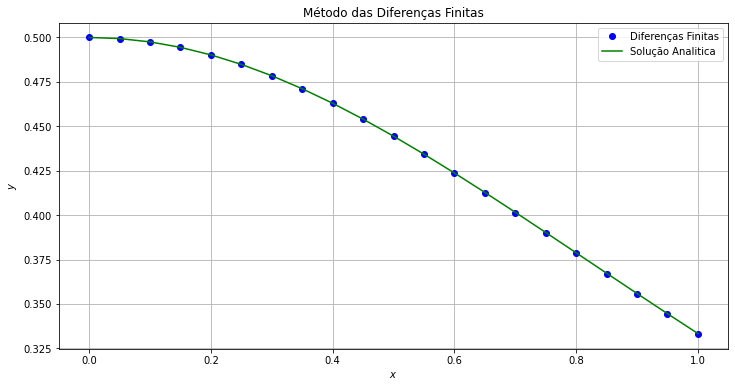

In [28]:
#Plotando os resultados
plt.figure()
plt.title('Método das Diferenças Finitas')
plt.plot(x, y, 'bo', label = 'Diferenças Finitas')
plt.plot(x, z, 'g', label = 'Solução Analitica')
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()